### This notebook is made for the case when having saturation on the steering rate. Since we need to let the RL-agent know what the current steering angle is (otherwise it can't learn how much it is allowed to change the steering angle) we it is included in the state. So the states are the 2 states from the transfer function $\varphi(s) = G(s)\delta(s)$, as well as the speed v and the steering angle $\delta$.

In [1]:
import math
import random
import time

import gym
import numpy as np
import scipy.linalg

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA on GPU if avaliable</h2>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments to run in parallel</h2>

In [4]:
from Bike_4states import Bike_4statesEnv # import the custom environment class
from multiprocessing_env import SubprocVecEnv

num_envs = 64

def make_env():
    def _thunk():
        env = Bike_4statesEnv()
        return env

    return _thunk

# Parallel environments used for training:
envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

# Single environment used for evaluating:
env = Bike_4statesEnv()

<h2>Neural Network</h2>

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        # Critic network:
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        # Actor network:
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        # log-stadard deviation parameter:
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

### Functions for plotting and evaluating the training process

In [6]:
# Plot the rewards:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('update %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

# Evalute the cumulative reward for the current RL-agent:
def test_env(vis=False, init_state=None, num_steps_eval=int(1e9)):
    '''
    vis - boolean that desides if the bike will be rendered or not
    init_state - makes it possible to specify the initial state
    num_steps_eval - for how many time steps the sequence will last
    '''
    
    # If an initial state in inputed, then it will be used, otherwise the intial state will be specified by
    # environment:
    if type(init_state) == np.ndarray:
        state = env.reset(init_state=init_state)
    else:
        state = env.reset()
    
    # render illuatration of the bike at the intial state if vis is true:
    if vis: env.render()
    
    
    done = False
    total_reward = 0
    for i in range(num_steps_eval):
        state = torch.FloatTensor(state).unsqueeze(0).to(device) # convert the current state to torch format
        dist, _ = model(state) # get the distribution for the action from the current RL-agent
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0]) # sample an action from the
                                                                               # distribution as well as
                                                                               # converting back from torch format
        state = next_state
        
        # If vis is true, render the bike at the current state, as well as pause for a short while so that it
        # becomes easier to follow the animation
        if vis:
            time.sleep(0.1)
            env.render() 
        
        # Add the reward for the current time step to the total reward:
        total_reward += reward
        
        # If a terminal state is reached, then end loop:
        if done:
            break
            
    return total_reward


# When having random initial conditions, you may need the average of a lot of sequences to get a good indication
# of how well the current agent is doing. With this function you can instead choose to evaluate the current
# RL-agent on specific intial conditions. Let's say you train on phi = uni(-5, 5) deg and v = uni(0.5, 10), then 
# you could for example choose to only evaulate the network at phi = -5 deg and phi = 5 deg and v = 0.5, 5 and 
# 10. The initial conditions for delta is always 0.
def test_env_with_certain_initial_conditions(num_run_throughs=4, 
                                                              phi_ICs=[np.deg2rad(0.5), np.deg2rad(-0.5)],
                                                              v_ICs=[0.5, 5, 10],
                                                              num_steps_eval = 100):   
    '''num_run_throuhgs - even though the initial conditions are fixed, there still exists some randomness
    when the action is sampled. So num_run_throughs is the number times you evaluate all of the permutations of
    the initial conditions.
    
    phi_ICS - initial conditions for the roll angle phi (radians)
    
    v_ICs - inital conditinos for the speed v
    
    '''
    
    sum_of_cumulative_rewards_for_every_initial_condtition = 0
    
    for i in range(num_run_throughs):
        for v_0 in v_ICs:
            for phi_0 in phi_ICs:
                init_state = np.array([phi_0, 0, v_0, 0], dtype=np.float32)
                sum_of_cumulative_rewards_for_every_initial_condtition += test_env(init_state=init_state,
                                                                                  num_steps_eval = num_steps_eval)
    
    num_of_episodes_tested = num_run_throughs * len(phi_ICs) * len(v_ICs)
    mean_of_cumulative_rewards_for_every_initial_condtition = 1/num_of_episodes_tested * sum_of_cumulative_rewards_for_every_initial_condtition
    
    return mean_of_cumulative_rewards_for_every_initial_condtition


# This function is used for getting the state trajectory for a state using the current RL-agent:
def get_state_sequence(state_0):
    state = state_0.copy()
    phi_sequence = [state[0]]
    v_sequence = [state[2]]
    delta_sequence = [state_0[3]]
    done = False
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device) # convert the current state to torch format
        dist, _ = model(state) # get the distribution for the action from the current RL-agent
        action = dist.sample().cpu().numpy()[0] # sample an action from the distribution
        next_state, reward, done, _ = env.step(action) # take step in env using the action from the agent
        
        # Append the new states:
        phi_sequence.append(next_state[0])
        delta_sequence.append(next_state[3])
        v_sequence.append(next_state[2])
        state = next_state.copy()
    return phi_sequence, delta_sequence, v_sequence

<h2>Function for calculating the GAE, generalized advantage estimation</h2>

In [7]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [8]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

### Hyperparameters and initiation of model and optimizer:

In [9]:
# The number of state elements is the number of inputs to the neural networks. The size of the state-space
# (or observation space) is fetched from the environment (since we have 4 states it will be 4):
num_inputs  = envs.observation_space.shape[0]
# The output of the actor network is the size of the action space. The size of the state-space
# is fetched from the environment (since delta is the only action it will be 1):
num_outputs = envs.action_space.shape[0]


hidden_size      = 32 # Number of neurons per hidden layer
num_steps_train  = 100 # Length of sequences to train the agent on
num_steps_eval   = 100 # Length of sequences to evaluate the agent on
mini_batch_size  = 64 # The size of the mini batches that the neural network will be trained on. Should not be
                      # larger than num_steps_train*num_envs (=the batch size)
ppo_epochs       = 4 # Number of times the entire batch get passed through the network
threshold_reward = np.inf # Use if you would like to stop the training when a certian average cumulative rewards
                       # is reached. 
gamma = 0.99 # discount factor

# Learning rate
lr = 1e-3

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

### Load best network.
#### When the training progress has crashed or stagnated: restart the kernel, lower the learning rate and uncomment the model.load_state_dict... You can also change highest_test_reward to the best reward you got, but the only thing it does is that the best performing netowork will not be overwritten if the score is lower than it.

In [10]:
#model.load_state_dict(torch.load('saved_networks/best_network'))
highest_test_reward = -np.inf # Previous highest reward
highest_test_reward = 279
test_rewards = []

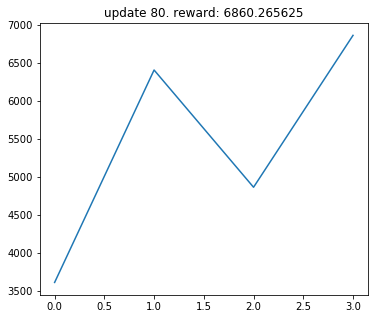

Rewards: [3609.125, 6404.21875, 4861.84375, 6860.265625]
Current learning rate: 0.001


KeyboardInterrupt: 

In [11]:
max_ppo_updates = 40000 # Upper limit on how many training updates that can be done
ppo_update_idx  = 0
state = envs.reset()
early_stop = False

while ppo_update_idx < max_ppo_updates and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0
    state = envs.reset()
    
    # Collect sequences from the current agent:
    for _ in range(num_steps_train):
        state = torch.FloatTensor(state).to(device)
        # Get the action distribution and the value for all the state of each paralell environment:
        dist, value = model(state)

        action = dist.sample() # Sample action from the distribution
        next_state, reward, done, _ = envs.step(action.cpu().numpy()) # Take a step with the action

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
              

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values, gamma = gamma)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    # The neural networks are updated here:
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    
    ppo_update_idx += 1
    # Every 20th update, the agent is evaluated and the average reward is plotted toghether with the previous
    # ones. Also the network is saved in the checkpoint folder, and the best_network is overwritten if the
    # reward is the highest as of yet:
    if ppo_update_idx % 20 == 0:
        # If you want to use the default initial conditions of the environment:
        #test_reward = np.mean([test_env(num_steps_eval = num_steps_eval) for _ in range(64)])
        
        # If you want to evalate on fixed initial conditions to make it easier to compare results, when having
        # random initial conditions in the environment.
        # nr of episodes used for the test are num_run_throughs*len(phi_ICs)*len(v_ICs):
        test_reward = test_env_with_certain_initial_conditions(num_run_throughs=32, 
                                                              phi_ICs=[np.deg2rad(5), np.deg2rad(-5)],
                                                              v_ICs=[0.9], num_steps_eval=num_steps_eval)
        test_rewards.append(test_reward)
        plot(ppo_update_idx, test_rewards)
        print('Rewards:', test_rewards)
        print('Current learning rate:', lr)
        if test_reward > threshold_reward: early_stop = True
            
        # Overwrite best_network if highest reward as of yet is reached:
        if test_reward > highest_test_reward:
            torch.save(model.state_dict(), 'saved_networks/best_network')
            highest_test_reward = test_reward
            
        # Checkpoints are saved continously, so not just the best network is saved:
        torch.save(model.state_dict(), 'saved_networks/checkpoints/checkpoint_idx' + str(ppo_update_idx) + '_reward'
                      +str(round(test_reward,2)))
        
        

### Save and load a model:

In [11]:
# Save:
#torch.save(model.state_dict(), 'saved_networks/ppo_network')


# Load:
#model.load_state_dict(torch.load('saved_networks/ppo_network'))
#model.load_state_dict(torch.load('saved_networks/ppo_demo_speed=0.9_phi0=5_2hiddenlayers_32nodes'))


<All keys matched successfully>

### Get average cumulative reward for specified initial conditions:

In [13]:
test_env_with_certain_initial_conditions(num_run_throughs=32, 
                                        phi_ICs=[np.deg2rad(-5), np.deg2rad(5)],
                                        v_ICs=[0.9],
                                        num_steps_eval = num_steps_eval)

33.25

### Get average cumulative reward for initial conditions specified in the enviroment:

In [11]:
test_reward = np.mean([test_env(num_steps_eval = num_steps_eval) for _ in range(200)])
test_reward

286.24

### Render

In [17]:
init_phi = np.deg2rad(5)
init_x2 = 0 # non-intuitive state from transfer function
init_v = 0.9
init_state = np.array([init_phi, init_x2, init_v, 0], dtype=np.float32)
num_steps_to_render = 100
test_env(vis=True, init_state=init_state, num_steps_eval=num_steps_to_render)
env.close()

### Plot sequnce. The results of the RL-agent is compared to that of a LQR.

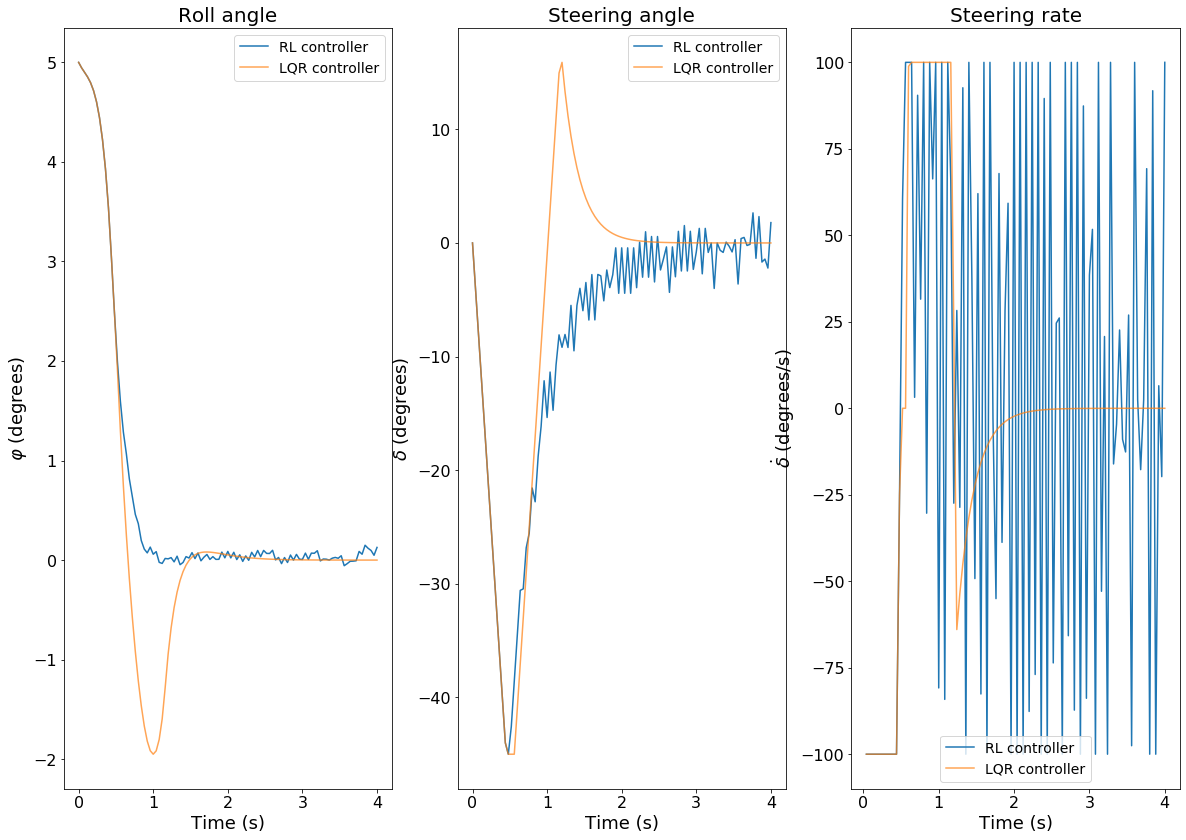

In [12]:
init_phi = np.deg2rad(5)
init_x2 = 0 # non-intuitive state from transfer function
init_v = 0.9
init_state = np.array([init_phi, init_x2, init_v, 0], dtype=np.float32)

state_0 = env.reset(init_state=init_state)
phi_sequence, delta_sequence, velocity = get_state_sequence(state_0)

Ts = 0.04
t = np.arange(0, len(phi_sequence)*Ts, Ts)
fig, axes = plt.subplots(1, 3, figsize=(20,14))

# Roll angle (with RL controller):
axes[0].plot(t, np.rad2deg(phi_sequence), label = "RL controller")
axes[0].set_xlabel('Time (s)', fontsize = 18)
axes[0].set_ylabel(r'$\varphi$ (degrees)', fontsize = 18)
axes[0].set_title('Roll angle', fontsize=20)
axes[0].tick_params(axis="x", labelsize=16)
axes[0].tick_params(axis="y", labelsize=16)

# Steering angle (with RL controller)
axes[1].plot(t, np.rad2deg(delta_sequence), label="RL controller")
axes[1].set_xlabel('Time (s)', fontsize = 18)
axes[1].set_ylabel('$\delta$ (degrees)', fontsize = 18)
axes[1].set_title('Steering angle', fontsize = 20);
axes[1].tick_params(axis="x", labelsize=16)
axes[1].tick_params(axis="y", labelsize=16)

# Steering angle rate (with RL controller)
axes[2].plot(t[1:], np.rad2deg(np.diff(delta_sequence))/env.dt, label="RL controller")
axes[2].set_xlabel('Time (s)', fontsize = 18)
axes[2].set_ylabel('$\dot{\delta}$ (degrees/s)', fontsize = 18)
axes[2].set_title('Steering rate', fontsize = 20);
axes[2].tick_params(axis="x", labelsize=16)
axes[2].tick_params(axis="y", labelsize=16)


# Plotting the sequences using an LQR as well (they come from using the K gain from the dlqr algorithm)
from utility_functions_4states import get_optimal_sequence
Q = np.array([[1, 0], [0, 0]], dtype=np.float32)
R = 1
optimal_phi_sequence, optimal_delta_sequence = get_optimal_sequence(init_state, env, Q, R, num_steps_eval)
t_optimal = np.arange(0, len(optimal_phi_sequence)*Ts, Ts)

# Roll angle (with LQR):
axes[0].plot(t_optimal, np.rad2deg(optimal_phi_sequence), alpha=0.7, label = "LQR controller")
axes[0].legend(fontsize=14)
# Steering angle (with LQR):
axes[1].plot(t_optimal, np.rad2deg(optimal_delta_sequence), alpha=0.7, label="LQR controller")
axes[1].legend(fontsize=14);
# Steering angle rate (with LQR)
axes[2].plot(t_optimal[1:], np.rad2deg(np.diff(optimal_delta_sequence))/env.dt, alpha=0.7, label="LQR controller")
axes[2].legend(fontsize=14);